In [489]:
from collections import Counter
from decimal import Decimal
from gensim.models import Word2Vec
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import jieba
import json
import matplotlib.pyplot as plt
import nltk
nltk.download('words')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import re
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from tqdm import tqdm
from wordcloud import WordCloud
font = 'font_ch.ttf'



[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [492]:
taobao_gym = pd.read_csv('Taobao/Taobao-query=健身-searchResult.csv')
taobao_gym = taobao_gym[taobao_gym['Title'].notnull()]
taobao_gym = taobao_gym.iloc[:, 5:16]
taobao_gym.isnull().sum()

taobao_gym = taobao_gym.reset_index().drop(['index'], axis=1).reset_index()
taobao_gym = taobao_gym.assign(page=(taobao_gym['index'] / 40).round().astype(int) + 1).drop(['index'], axis=1)
taobao_gym = taobao_gym.iloc[:,3:12]
taobao_gym


Title          0
Title_URL      0
Image          0
Keywords       0
Keywords1      0
Tag           27
Type          98
Price          0
Price2       100
Number         0
Comment        0
dtype: int64

,Keywords,Keywords1,Tag,Type,Price,Price2,Number,Comment,page
0,\n 健腹輪腹肌懶人健身器減腹瘦肚子神器家...,\n \n ...,表面軟的,新品嚐鮮,289.0,\n ￥399\n ...,已售6500+件,2500+評價,1
1,\n 奧克斯專業級筋膜槍肌肉放鬆電動按摩器...,\n \n ...,能緩解疲勞,聚劃算,398.0,\n ￥399.9\n ...,已售8500+件,1000+評價,1
2,\n 湯臣倍健增肌粉乳清蛋白粉健身瘦子增肌...,\n \n ...,溶解徹底,優惠促銷,288.0,\n ￥398\n ...,已售2万+件,3万+評價,1
3,\n Nutrend諾特蘭德純乳清蛋白質粉...,\n \n ...,送人滿意,店鋪活動,218.0,\n ￥599\n ...,已售7000+件,1万+評價,1
4,\n 筋膜槍肌肉放鬆按摩器電動家用頸膜機儀...,\n \n ...,低頭族很喜歡,聚劃算,129.0,\n ￥898\n ...,已售4万+件,3万+評價,1
...,...,...,...,...,...,...,...,...,...
898,\n 維特客假兩件訓練美式短褲男健身跑步運...,\n \n ...,褲兜還有拉鍊,好貨也瘋狂,99.9,\n ￥159\n ...,已售1333件,6000+評價,23
899,\n 運動內衣女減防震防下垂夏季跑步美背聚...,\n \n ...,減震效果好,新品上新,39.9,\n ￥55\n ...,已售1702件,200+評價,23
900,\n 美國漢臣 健身車靜音室內減肥健身車運...,\n \n ...,上檔次,活動中,1590.0,\n ￥5360\n ...,已售68件,100+評價,23
901,\n VFU健身褲女提臀彈力收腹跑步訓練運...,\n \n ...,NaN,全民瘋搶,189.0,\n ￥239\n ...,已售1万+件,1000+評價,24


In [493]:
taobao_gym['Title'] = taobao_gym['Keywords'].apply(lambda x: x.split('\n')[1].strip())
taobao_gym['Keywords'] = taobao_gym['Keywords1'].apply(lambda x: [char for char in [char.strip() for char in x.strip().split('\n')] if char != ''])
taobao_gym['original_price'] = taobao_gym['Price2'].apply(lambda x: float(x.strip()[1:]) if type(x) != float else x)
taobao_gym['Number'] = taobao_gym['Number'].apply(lambda x: x.replace('已售', '').replace('件', '').replace('+', '').replace('万', '0000'))
taobao_gym['Comment'] = taobao_gym['Comment'].apply(lambda x: x.replace('評價', '').replace('+', '').replace('万', '0000'))
taobao_gym = taobao_gym.rename(columns={'Price': 'sale_price'})
taobao_gym['original_price'] = taobao_gym['original_price'].fillna(taobao_gym['sale_price'])
taobao_gym['discount'] = taobao_gym['original_price'] - taobao_gym['sale_price']
taobao_gym = taobao_gym.drop(['Keywords1', 'Tag', 'Price2'], axis=1)
for col in ['Number', 'Comment']:
    taobao_gym[col] = taobao_gym[col].astype(int)

taobao_gym = taobao_gym.loc[taobao_gym.Title.drop_duplicates().index].reset_index().drop(['index'], axis=1)
taobao_gym = taobao_gym[['Title', 'Keywords', 'Type', 'original_price', 'sale_price', 'Number', 'Comment', 'page']]
taobao_gym.columns = [col.lower() for col in taobao_gym.columns]
taobao_gym


,title,keywords,type,original_price,sale_price,number,comment,page
0,健腹輪腹肌懶人健身器減腹瘦肚子神器家用健身器材自動回彈健腹器,"[表面軟的, 靜音效果特好, 很大效果, 很適合家庭用, 計數有動力]",新品嚐鮮,399.0,289.0,6500,2500,1
1,奧克斯專業級筋膜槍肌肉放鬆電動按摩器儀頸膜搶健身上肌膜機492,"[能緩解疲勞, 品牌可靠, 檔位可調節, 大小合適, 操作很方便, 物流速度很快]",聚劃算,399.9,398.0,8500,1000,1
2,湯臣倍健增肌粉乳清蛋白粉健身瘦子增肌增重健肌粉男肌肉營養減脂,"[溶解徹底, 沒疲憊感, 還瘦了兩斤, 巧克力味很香, 老公很喜歡]",優惠促銷,398.0,288.0,20000,30000,1
3,Nutrend諾特蘭德純乳清蛋白質粉增健肌粉健身男瘦人增重2.5磅whey,"[送人滿意, 增肌效果棒, 可以減肥, 沒有副作用, 跟藥店無差別]",店鋪活動,599.0,218.0,7000,10000,1
4,筋膜槍肌肉放鬆按摩器電動家用頸膜機儀健身勁膜搶mini肌膜儀,"[低頭族很喜歡, 液晶螢幕, 力道很, 樣式挺高檔, 沒疲憊感]",聚劃算,898.0,129.0,40000,30000,1
...,...,...,...,...,...,...,...,...
822,維特客假兩件訓練美式短褲男健身跑步運動速乾透氣馬拉鬆三分褲夏,"[褲兜還有拉鍊, 速乾性很好, 打籃球穿好看, 健身, 可以穿着打球]",好貨也瘋狂,159.0,99.9,1333,6000,23
823,運動內衣女減防震防下垂夏季跑步美背聚攏健身背心瑜伽服文胸上衣,"[減震效果好, 碼數標準, 很透氣, 很舒服, 面料柔軟, 樣式好看]",新品上新,55.0,39.9,1702,200,23
824,美國漢臣 健身車靜音室內減肥健身車運動自行車瘦SHARP X1,"[上檔次, 沒有噪音, 運轉聲音很小, 很舒適, 圖片顏色很正, 組裝很簡單]",活動中,5360.0,1590.0,68,100,23
825,VFU健身褲女提臀彈力收腹跑步訓練運動休閒外穿打底蜜桃臀瑜伽服,[],全民瘋搶,239.0,189.0,10000,1000,24


In [161]:
taobao_gym.to_csv('cleansed-taobao-searchQuery=健身.csv', index=False)


In [495]:
taobao_gym = pd.read_csv('Taobao/Preprocessed-Taobao-query=健身-searchResult.csv')


#### jieba

In [500]:
def product_name_cleansing(x):
    char_replace_dict = {
        '筋膜槍': ['頸膜搶','肌膜機','勁膜搶','頸膜機','肌膜儀','經膜機','經膜儀'],
        '啞鈴': ['亞鈴','亞玲'],
        '瑜珈': ['喻咖'],
        '健腹儀': ['健腹儀','健腹器'],
        '劃水機': ['劃船機','劃船器']
    }
    for k, v in char_replace_dict.items():
        for char in v:
            x = x.replace(char, k)
            
    return x
            
taobao_gym['title'] = taobao_gym['title'].apply(lambda x: product_name_cleansing(x))
taobao_gym.title.values


array(['健腹輪腹肌懶人健身器減腹瘦肚子神器家用健身器材自動回彈健腹儀',
       '奧克斯專業級筋膜槍肌肉放鬆電動按摩器儀筋膜槍健身上筋膜槍492',
       '湯臣倍健增肌粉乳清蛋白粉健身瘦子增肌增重健肌粉男肌肉營養減脂',
       'Nutrend諾特蘭德純乳清蛋白質粉增健肌粉健身男瘦人增重2.5磅whey',
       '筋膜槍肌肉放鬆按摩器電動家用筋膜槍儀健身筋膜槍mini筋膜槍',
       '2磅康比特乳清蛋白質粉低脂whey營養增健肌粉健身男女瘦人肌肉粉',
       '宋軼同款不會掉智能呼啦圈收腹加重減肥神器健身專用女瘦肚子瘦腰', '計數無線跳繩健身減肥運動負重款專業燃脂女專用重力無線球無線子',
       '簡美健身會所專業營養師一對一定製減肥配餐食譜計劃指導監督教練',
       '鑫友M7跑步機家用小型女男摺疊靜音室內家庭式健身房專用健身器材',
       '億健ELF跑步機家用款小型可摺疊多功能靜音家庭式室內健身房專用',
       '門上單槓家用室內兒童免打孔牆體引體向上器小孩單杆家庭健身器材', '康比特果粒增肌粉乳清蛋白質營養粉健身男女瘦人增重增肥健肌粉',
       'Schardinger 莎丁格 1L*12盒 脫脂牛奶  學生早餐減脂健身 奧地利',
       '麥瑞克超燃脂跑步機家用款小型摺疊靜音健身房專用HUAWEI HiLink',
       '飛力仕多功能運動震顫健身彈力訓練棒飛力士菲利斯震震燃脂甩脂棒',
       '肌肉科技左旋肉鹼100000官方旗艦店正品cla健身運動飲料右鹼十萬',
       '麥瑞克健身車家用運動磁控健身自行車室內減肥器超靜音絕影CC', '美國腹肌貼健身速成神器智能健帖儀懶人男女收腹機瘦肚子減肥器材',
       '簡美健身會所健身減肥計劃定製指導監督私人教練減脂瘦身食譜增肌',
       'Muscletech肌肉科技增肌粉純乳清蛋白質粉健身瘦人增肌增重健肌男',
       '志高筋膜槍肌肉放鬆電動按摩器儀筋膜槍多功能健身震動迷你專業級', '淫羊藿膠囊雄性激素補充片男性保健品補睾丸酮健身增肌促睾補劑',
       '富貴鳥智能呼啦圈收腹減肥加重宋軼同款健身女專用瘦腰瘦肚子神器',
       '營

In [501]:
# jieba.set_dictionary('dict.txt.big')
jieba.load_userdict('custom_dict.txt')
taobao_gym['title_jiebaCut'] = taobao_gym['title'].apply(lambda x: [char.strip() for char in jieba.cut(x, cut_all=False)])
taobao_gym


,title,keywords,type,original_price,sale_price,number,comment,page,title_jiebaCut
0,健腹輪腹肌懶人健身器減腹瘦肚子神器家用健身器材自動回彈健腹儀,"['表面軟的', '靜音效果特好', '很大效果', '很適合家庭用', '計數有動力']",新品嚐鮮,399.0,289.0,6500,2500,1,"[健腹輪, 腹肌, 懶人, 健身器, 減腹, 瘦肚子, 神器, 家用, 健身器材, 自動, ..."
1,奧克斯專業級筋膜槍肌肉放鬆電動按摩器儀筋膜槍健身上筋膜槍492,"['能緩解疲勞', '品牌可靠', '檔位可調節', '大小合適', '操作很方便', '物...",聚劃算,399.9,398.0,8500,1000,1,"[奧克斯, 專業級, 筋膜槍, 肌肉, 放鬆, 電動, 按摩器儀, 筋膜槍, 健身, 上, ..."
2,湯臣倍健增肌粉乳清蛋白粉健身瘦子增肌增重健肌粉男肌肉營養減脂,"['溶解徹底', '沒疲憊感', '還瘦了兩斤', '巧克力味很香', '老公很喜歡']",優惠促銷,398.0,288.0,20000,30000,1,"[湯臣倍, 健, 增肌, 粉, 乳清, 蛋白粉, 健身, 瘦子, 增肌, 增重, 健肌粉, ..."
3,Nutrend諾特蘭德純乳清蛋白質粉增健肌粉健身男瘦人增重2.5磅whey,"['送人滿意', '增肌效果棒', '可以減肥', '沒有副作用', '跟藥店無差別']",店鋪活動,599.0,218.0,7000,10000,1,"[Nutrend, 諾特蘭德, 純乳清, 蛋白質粉, 增, 健肌粉, 健身, 男瘦, 人, ..."
4,筋膜槍肌肉放鬆按摩器電動家用筋膜槍儀健身筋膜槍mini筋膜槍,"['低頭族很喜歡', '液晶螢幕', '力道很', '樣式挺高檔', '沒疲憊感']",聚劃算,898.0,129.0,40000,30000,1,"[筋膜槍, 肌肉, 放鬆, 按摩器, 電動, 家用, 筋膜槍, 儀, 健身, 筋膜槍, mi..."
...,...,...,...,...,...,...,...,...,...
822,維特客假兩件訓練美式短褲男健身跑步運動速乾透氣馬拉鬆三分褲夏,"['褲兜還有拉鍊', '速乾性很好', '打籃球穿好看', '健身', '可以穿着打球']",好貨也瘋狂,159.0,99.9,1333,6000,23,"[維特客, 假兩件, 訓練, 美式, 短褲, 男, 健身, 跑步, 運動, 速乾, 透氣, ..."
823,運動內衣女減防震防下垂夏季跑步美背聚攏健身背心瑜伽服文胸上衣,"['減震效果好', '碼數標準', '很透氣', '很舒服', '面料柔軟', '樣式好看']",新品上新,55.0,39.9,1702,200,23,"[運動, 內衣, 女減, 防震, 防下垂, 夏季, 跑步, 美背, 聚攏, 健身, 背心, ..."
824,美國漢臣 健身車靜音室內減肥健身車運動自行車瘦SHARP X1,"['上檔次', '沒有噪音', '運轉聲音很小', '很舒適', '圖片顏色很正', '組裝...",活動中,5360.0,1590.0,68,100,23,"[美國, 漢臣, , 健身車, 靜音, 室內, 減肥, 健身車, 運動, 自行車, 瘦, S..."
825,VFU健身褲女提臀彈力收腹跑步訓練運動休閒外穿打底蜜桃臀瑜伽服,[],全民瘋搶,239.0,189.0,10000,1000,24,"[VFU, 健身褲, 女提, 臀, 彈力, 收腹, 跑步, 訓練, 運動, 休閒, 外穿, ..."


#### EDA
- boxplot

<Figure size 432x864 with 0 Axes>

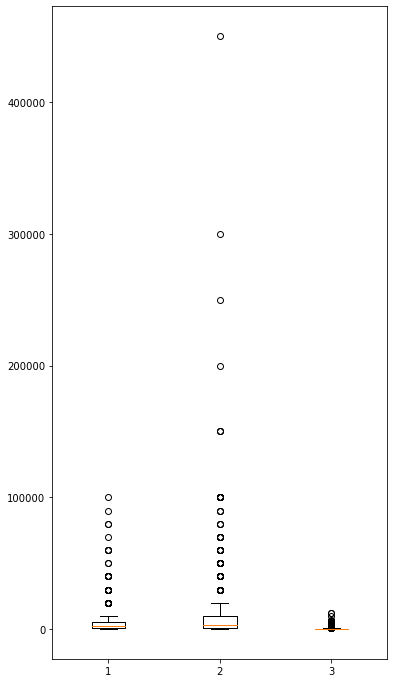

col:  number


array([ 775.,  775., 5500., 5500.,  775.])

(array([0.85, 1.15]), array([2156., 2156.]))

20000.0

100000.0

col:  comment


array([  650.,   650., 10000., 10000.,   650.])

(array([1.85, 2.15]), array([3000., 3000.]))

30000.0

450000.0

col:  sale_price


array([ 56.5,  56.5, 288. , 288. ,  56.5])

(array([2.85, 3.15]), array([99., 99.]))

639.0

12599.0

In [502]:
col_list = ['number', 'comment', 'sale_price']

plt.figure(figsize=(6, 12))
box_p = plt.boxplot(taobao_gym[col_list].values)

# plt.xlabel(x_axis)
# plt.ylabel(y_axis)
plt.show()

for i in range(len(col_list)):
    print('col: ', col_list[i])
    
    box_p['boxes'][i].get_data()[1]
    box_p['medians'][i].get_data()
    box_p['fliers'][i].get_data()[1].min()  # upper bound
    try:
        box_p['fliers'][i].get_data()[1].max()
    except:
        pass


In [503]:
taobao_gym[taobao_gym['title'].str.contains('初學者')].sort_values(['number'], ascending=False)

,title,keywords,type,original_price,sale_price,number,comment,page,title_jiebaCut
147,中歐瑜珈墊初學者防滑女加厚加寬加長健身男瑜珈舞蹈墊子地墊家用,"['摩擦力很強', '粉紅色很軟', '胳膊不疼', '活動力度很大', '很親切']",衝量促銷,103.00,12.9,100000,450000,5,"[中歐, 瑜珈墊, 初學者, 防滑, 女, 加厚, 加寬, 加長, 健身, 男, 瑜珈, 舞..."
42,悅步男士健身墊初學者瑜珈墊子加厚加寬加長防滑運動瑜珈地墊家用,"['材質很便捷', '新手可入', '會有聲音', '非常清涼', '很大']",新品秒殺,169.00,21.9,90000,50000,2,"[悅步, 男士, 健身墊, 初學者, 瑜珈墊子, 加厚, 加寬, 加長, 防滑, 運動, 瑜..."
46,瑜珈墊加厚加寬加長初學者女健身墊舞蹈防滑瑜珈墊子地墊家用瑜珈,"['一點也不滑', '不涼', '不冷', '防摔夠', '硬度合適']",熱賣促銷,118.00,58.0,40000,90000,2,"[瑜珈墊, 加厚, 加寬, 加長, 初學者, 女, 健身墊, 舞蹈, 防滑, 瑜珈墊子, 地..."
108,奧義男士健身墊初學者瑜珈墊子加厚加寬加長防滑運動瑜珈地墊家用,"['隔音效果不錯', '適合減肥', '有品牌', '色彩比較顯眼', '吸汗效果好']",優惠促銷,158.00,21.9,40000,50000,4,"[奧義, 男士, 健身墊, 初學者, 瑜珈墊子, 加厚, 加寬, 加長, 防滑, 運動, 瑜..."
111,瑜珈墊初學者女男士加厚加寬加長健身舞蹈防滑跳繩瑜珈地墊子家用,"['很多個小孔', '做運動夠用', '紫色太神仙', '很輕騎', '靜音效果好']",特賣直營,22.35,14.9,40000,10000,4,"[瑜珈墊, 初學者, 女, 男士, 加厚, 加寬, 加長, 健身, 舞蹈, 防滑, 跳繩, ..."
119,中歐男士健身墊初學者瑜珈墊子加厚加寬加長防滑瑜珈運動地墊家用,"['空間足夠伸展', '密度緊緻', '好平', '不涼', '風格非常般配']",火爆促銷,299.00,21.9,30000,60000,4,"[中歐, 男士, 健身墊, 初學者, 瑜珈墊子, 加厚, 加寬, 加長, 防滑, 瑜珈, 運..."
130,Keep瑜珈墊初學者防滑加厚加寬舞蹈墊跳繩健身男士瑜珈地墊家用,"['退差價', '底部有紋理', '不會漏水', '初學者適合', '全新']",NaN,99.00,99.0,20000,60000,4,"[Keep, 瑜珈墊, 初學者, 防滑, 加厚, 加寬, 舞蹈墊, 跳繩, 健身, 男士, ..."
363,派普瑜珈墊初學者健身男加厚加寬加長防滑瑜珈墊子地墊家用女運動,"['高度剛好好', '粉紅色很漂亮', '補了差價', '不冰', '色澤']",活動促銷,113.00,12.9,20000,200000,11,"[派普, 瑜珈墊, 初學者, 健身, 男, 加厚, 加寬, 加長, 防滑, 瑜珈墊子, 地墊..."
234,中歐男士健身墊初學者瑜珈墊子加厚加寬加長防滑運動瑜珈地墊家用,"['隔音不錯', '放地上很穩當', '全新', '很適合健身', '很厚']",火爆促銷,199.00,14.9,20000,100000,8,"[中歐, 男士, 健身墊, 初學者, 瑜珈墊子, 加厚, 加寬, 加長, 防滑, 運動, 瑜..."
352,男士健身墊初學者瑜珈墊子加厚加寬加長2米防滑瑜珈運動地墊家用,"['洗了後很平整', '摩擦給力', '很寬', '吸汗不錯', '沒有塑料味']",店鋪優惠,199.00,13.8,20000,40000,11,"[男士, 健身墊, 初學者, 瑜珈墊子, 加厚, 加寬, 加長, 2, 米, 防滑, 瑜珈,..."


- Observe outliers
    - 銷量 outlier 商品標題段詞詞頻中，與 non_outlier 比較後，商品標題包含「初學者」、「無線」、「防滑」頻率相對高
        - 查詢後發現是「無線跳繩」和「防滑瑜珈墊」屬於熱銷爆品
    

products:  207


<Figure size 720x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

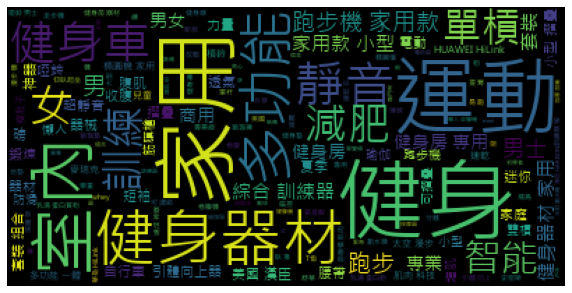

products:  207


<Figure size 720x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

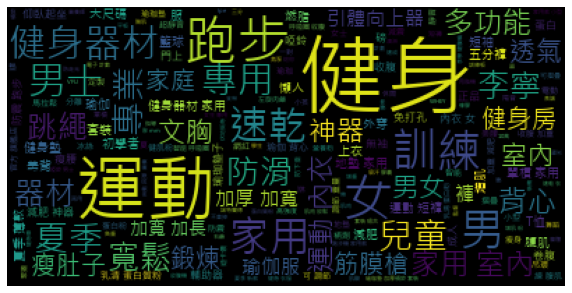

products:  207


<Figure size 720x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

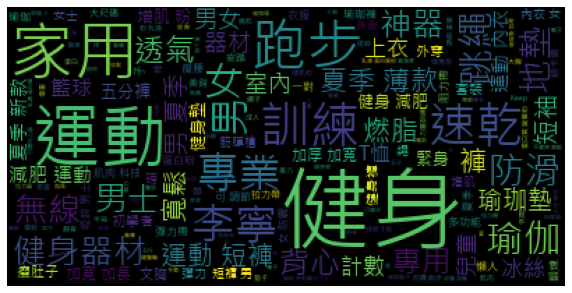

products:  176


<Figure size 720x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

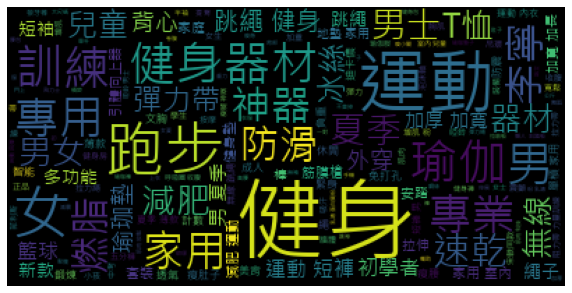

products:  30


<Figure size 720x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

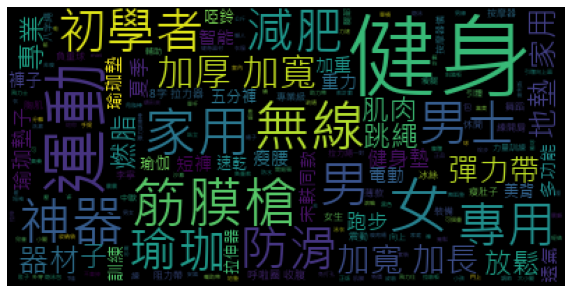

In [504]:
# 銷量 outliers
# taobao_gym[taobao_gym['number'] > 20000]

title_jiebaCut_sale_num_Q1 = taobao_gym[taobao_gym['number'] <= 775]
title_jiebaCut_sale_num_Q1_Q2 = taobao_gym[(taobao_gym['number'] > 775) & (taobao_gym['number'] <= 2156)]
title_jiebaCut_sale_num_Q2_Q3 = taobao_gym[(taobao_gym['number'] > 2156) & (taobao_gym['number'] <= 5500)]
title_jiebaCut_sale_num_Q3 = taobao_gym[(taobao_gym['number'] > 5500) & (taobao_gym['number'] <= 20000)]
title_jiebaCut_sale_num_outliers = taobao_gym[taobao_gym['number'] > 20000]


for l in [title_jiebaCut_sale_num_Q1, title_jiebaCut_sale_num_Q1_Q2, 
          title_jiebaCut_sale_num_Q2_Q3, title_jiebaCut_sale_num_Q3, title_jiebaCut_sale_num_outliers]:
    
    print('products: ', len(l))
    plt.figure(figsize=(10, 10))
    wc = WordCloud(background_color='black', font_path=font).generate(' '.join(l.title_jiebaCut.sum()))
    plt.imshow(wc)
    plt.axis('off')
    plt.show();



products:  904


<Figure size 720x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

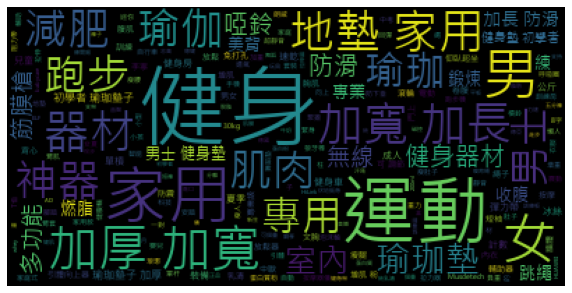

products:  10820


<Figure size 720x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

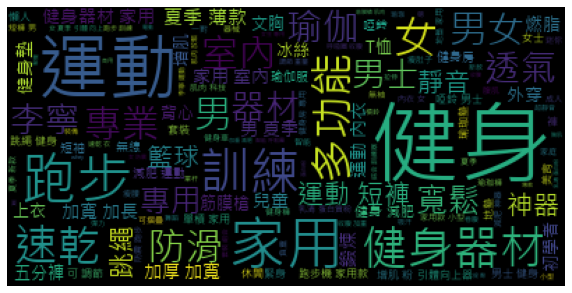

In [505]:
# 評論數 outliers
# taobao_gym[taobao_gym['comment'] > 30000]

title_jiebaCut_comment_outliers = taobao_gym[taobao_gym['comment'] > 30000].title_jiebaCut.sum()
title_jiebaCut_comment_nonOutliers = taobao_gym[taobao_gym['comment'] <= 30000].title_jiebaCut.sum()

for l in [title_jiebaCut_comment_outliers, title_jiebaCut_comment_nonOutliers]:
    
    print('products: ', len(l))
    plt.figure(figsize=(10, 10))
    wc = WordCloud(background_color='black', font_path=font).generate(' '.join(l))
    plt.imshow(wc)
    plt.axis('off')
    plt.show();

    

products:  1307


<Figure size 720x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

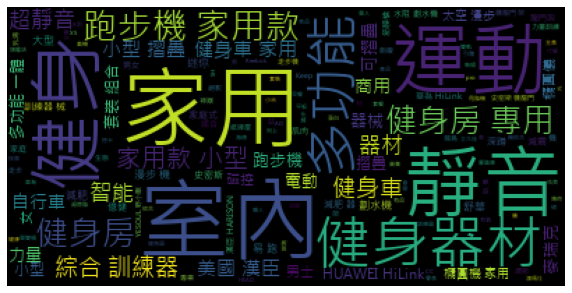

products:  10417


<Figure size 720x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

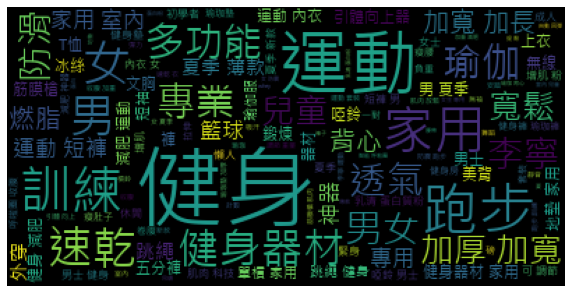

In [506]:
# 特惠售價 outliers
# taobao_gym[taobao_gym['sale_price'] > 639]

title_jiebaCut_salePrice_outliers = taobao_gym[taobao_gym['sale_price'] > 639].title_jiebaCut.sum()
title_jiebaCut_salePrice_nonOutliers = taobao_gym[taobao_gym['sale_price'] <= 639].title_jiebaCut.sum()

for l in [title_jiebaCut_salePrice_outliers, title_jiebaCut_salePrice_nonOutliers]:
    
    print('products: ', len(l))
    plt.figure(figsize=(10, 10))
    wc = WordCloud(background_color='black', font_path=font).generate(' '.join(l))
    plt.imshow(wc)
    plt.axis('off')
    plt.show();


- Quadrant Diagram

In [163]:
x_axis = 'comment'
y_axis = 'number'


<Figure size 576x576 with 0 Axes>

Text(0.5, 0, 'comment')

Text(0, 0.5, 'number')

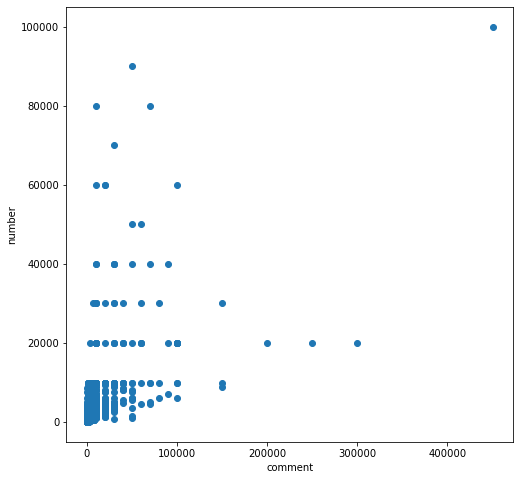

In [395]:
plt.figure(figsize=(8, 8))
plt.scatter(taobao_gym[x_axis].values, taobao_gym[y_axis].values)
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.show()


<Figure size 576x576 with 0 Axes>

Text(0.5, 0, 'comment')

Text(0, 0.5, 'number')

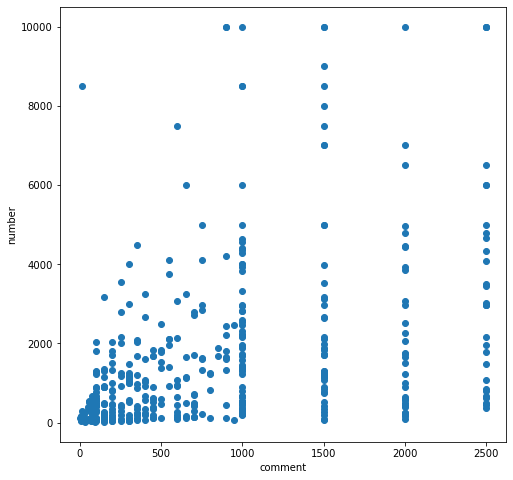

In [397]:
tmp = taobao_gym[taobao_gym[x_axis] < 3000]
plt.figure(figsize=(8, 8))
plt.scatter(tmp[x_axis].values, tmp[y_axis].values)
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.show()


#### Apply TF-IDF
統計方法，用以評估一字詞對於一個檔案集或一個語料庫中的其中一份檔案的重要程度


In [507]:
vectorizer = TfidfVectorizer(analyzer='word')#, max_df=1.0, min_df=0.2)
title_keywords_tfidf = vectorizer.fit_transform([' '.join(term_list) for term_list in taobao_gym.title_jiebaCut.values])
print(title_keywords_vector.shape)
print(vectorizer.get_feature_names())


(827, 1497)
['10', '100', '100000', '1000g', '1049', '10kg', '10萬', '11', '115plus', '12', '125', '15', '1l', '20', '200', '200ml', '2021', '2030kg', '20mm', '21天', '21天代餐', '30', '30kg', '361', '3900', '3omega3', '40', '408', '40kg', '450g', '492', '4kg5kg', '50', '518', '55', '5h', '5kg', '60', '60000', '65', '6500', '75', '750g', '75g', '773', '780g', '800t', '85', '8字', '90', '9119', '9119p', '919', 'a3', 'a5', 'a9', 'ab', 'ab3', 'ad', 'adidas', 'adidasadidas', 'air', 'allmax', 'annerun', 'app', 'aria', 'armour', 'asrv', 'athletics', 'b1900a', 'babycare', 'bacc', 'bcaa', 'bodydream', 'booster', 'bra', 'burn', 'c1', 'c1lite', 'calliven', 'cc', 'cla', 'colins', 'da5845', 'dcw', 'dha', 'e3', 'e7', 'eacute', 'eb', 'elf', 'equs', 'eyac', 'eyce', 'eyec', 'eys', 'eysc', 'eyzm', 'f3', 'faye', 'ffit8', 'fila', 'firstfit', 'fittergear', 'glutamine', 'gp7659', 'gymant', 'gymdog', 'harison', 'head', 'hellokitty', 'herbalife', 'hilink', 'huawei', 'huaweihilink', 'ifbb', 'ins', 'jet100', 'joinfi

In [508]:
tfidf_dict_list = list()
for i in tqdm(range(taobao_gym.shape[0])):
    _dict = dict()

    for k, v in zip(vectorizer.get_feature_names(), title_keywords_tfidf.toarray()[i]):
        if v > 0:
            _dict.update({k: v})
            
    tfidf_dict_list.append(_dict)

taobao_gym = taobao_gym.assign(tfidf_vector=tfidf_dict_list)
taobao_gym


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 827/827 [00:02<00:00, 298.87it/s]


,title,keywords,type,original_price,sale_price,number,comment,page,title_jiebaCut,tfidf_vector
0,健腹輪腹肌懶人健身器減腹瘦肚子神器家用健身器材自動回彈健腹儀,"['表面軟的', '靜音效果特好', '很大效果', '很適合家庭用', '計數有動力']",新品嚐鮮,399.0,289.0,6500,2500,1,"[健腹輪, 腹肌, 懶人, 健身器, 減腹, 瘦肚子, 神器, 家用, 健身器材, 自動, ...","{'健腹儀': 0.34256825110167205, '健腹輪': 0.32373968..."
1,奧克斯專業級筋膜槍肌肉放鬆電動按摩器儀筋膜槍健身上筋膜槍492,"['能緩解疲勞', '品牌可靠', '檔位可調節', '大小合適', '操作很方便', '物...",聚劃算,399.9,398.0,8500,1000,1,"[奧克斯, 專業級, 筋膜槍, 肌肉, 放鬆, 電動, 按摩器儀, 筋膜槍, 健身, 上, ...","{'492': 0.3176459070814156, '健身': 0.0744078567..."
2,湯臣倍健增肌粉乳清蛋白粉健身瘦子增肌增重健肌粉男肌肉營養減脂,"['溶解徹底', '沒疲憊感', '還瘦了兩斤', '巧克力味很香', '老公很喜歡']",優惠促銷,398.0,288.0,20000,30000,1,"[湯臣倍, 健, 增肌, 粉, 乳清, 蛋白粉, 健身, 瘦子, 增肌, 增重, 健肌粉, ...","{'乳清': 0.22161651163490773, '健肌粉': 0.282559724..."
3,Nutrend諾特蘭德純乳清蛋白質粉增健肌粉健身男瘦人增重2.5磅whey,"['送人滿意', '增肌效果棒', '可以減肥', '沒有副作用', '跟藥店無差別']",店鋪活動,599.0,218.0,7000,10000,1,"[Nutrend, 諾特蘭德, 純乳清, 蛋白質粉, 增, 健肌粉, 健身, 男瘦, 人, ...","{'nutrend': 0.440040152565875, 'whey': 0.32877..."
4,筋膜槍肌肉放鬆按摩器電動家用筋膜槍儀健身筋膜槍mini筋膜槍,"['低頭族很喜歡', '液晶螢幕', '力道很', '樣式挺高檔', '沒疲憊感']",聚劃算,898.0,129.0,40000,30000,1,"[筋膜槍, 肌肉, 放鬆, 按摩器, 電動, 家用, 筋膜槍, 儀, 健身, 筋膜槍, mi...","{'mini': 0.26920417155611004, '健身': 0.06831596..."
...,...,...,...,...,...,...,...,...,...,...
822,維特客假兩件訓練美式短褲男健身跑步運動速乾透氣馬拉鬆三分褲夏,"['褲兜還有拉鍊', '速乾性很好', '打籃球穿好看', '健身', '可以穿着打球']",好貨也瘋狂,159.0,99.9,1333,6000,23,"[維特客, 假兩件, 訓練, 美式, 短褲, 男, 健身, 跑步, 運動, 速乾, 透氣, ...","{'三分': 0.3463937109671407, '假兩件': 0.3313145174..."
823,運動內衣女減防震防下垂夏季跑步美背聚攏健身背心瑜伽服文胸上衣,"['減震效果好', '碼數標準', '很透氣', '很舒服', '面料柔軟', '樣式好看']",新品上新,55.0,39.9,1702,200,23,"[運動, 內衣, 女減, 防震, 防下垂, 夏季, 跑步, 美背, 聚攏, 健身, 背心, ...","{'上衣': 0.27929390646281504, '健身': 0.0932812921..."
824,美國漢臣 健身車靜音室內減肥健身車運動自行車瘦SHARP X1,"['上檔次', '沒有噪音', '運轉聲音很小', '很舒適', '圖片顏色很正', '組裝...",活動中,5360.0,1590.0,68,100,23,"[美國, 漢臣, , 健身車, 靜音, 室內, 減肥, 健身車, 運動, 自行車, 瘦, S...","{'sharp': 0.41082899640324405, 'x1': 0.4108289..."
825,VFU健身褲女提臀彈力收腹跑步訓練運動休閒外穿打底蜜桃臀瑜伽服,[],全民瘋搶,239.0,189.0,10000,1000,24,"[VFU, 健身褲, 女提, 臀, 彈力, 收腹, 跑步, 訓練, 運動, 休閒, 外穿, ...","{'vfu': 0.3274761050162627, '休閒': 0.2668858874..."


> 使用 tfidf 加權的詞頻輸入文字雲

products:  207


<Figure size 720x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

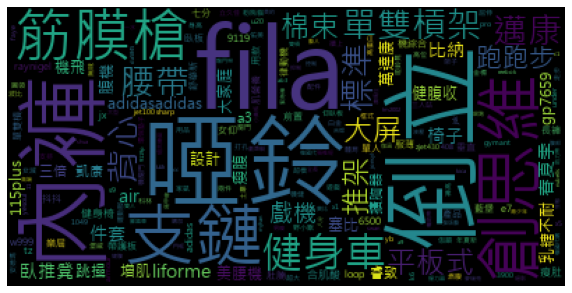

products:  207


<Figure size 720x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

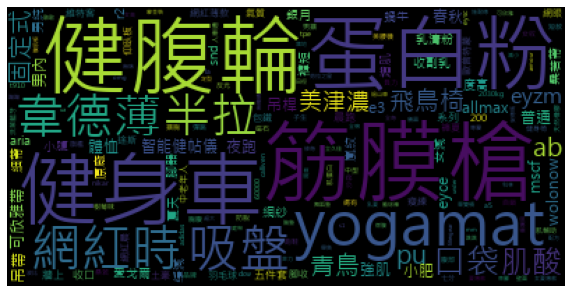

products:  207


<Figure size 720x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

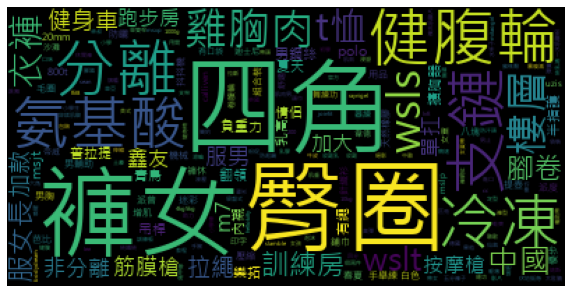

products:  176


<Figure size 720x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

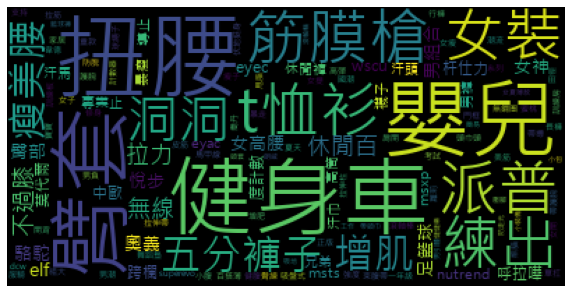

products:  30


<Figure size 720x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

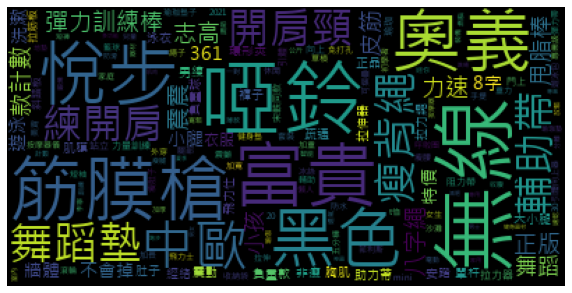

In [509]:
# 銷量 outliers, quantiles

title_jiebaCut_sale_num_Q1 = taobao_gym[taobao_gym['number'] <= 775]
title_jiebaCut_sale_num_Q1_Q2 = taobao_gym[(taobao_gym['number'] > 775) & (taobao_gym['number'] <= 2156)]
title_jiebaCut_sale_num_Q2_Q3 = taobao_gym[(taobao_gym['number'] > 2156) & (taobao_gym['number'] <= 5500)]
title_jiebaCut_sale_num_Q3 = taobao_gym[(taobao_gym['number'] > 5500) & (taobao_gym['number'] <= 20000)]
title_jiebaCut_sale_num_outliers = taobao_gym[taobao_gym['number'] > 20000]


for l in [title_jiebaCut_sale_num_Q1, title_jiebaCut_sale_num_Q1_Q2, 
          title_jiebaCut_sale_num_Q2_Q3, title_jiebaCut_sale_num_Q3, title_jiebaCut_sale_num_outliers]:
    
    print('products: ', l.shape[0])
#     kw_freq = np.sum([Counter(i.keys()) for i in l.tfidf_vector.values])
    freq_dict = dict()
    for i in l.tfidf_vector.values:
        freq_dict.update(i)

    plt.figure(figsize=(10, 10))
    wc = WordCloud(background_color='black', font_path=font).generate_from_frequencies(freq_dict)
    plt.imshow(wc)
    plt.axis('off')
    plt.show();



In [523]:
title_jiebaCut_sale_num_outliers
title_jiebaCut_sale_num_Q1


,title,keywords,type,original_price,sale_price,number,comment,page,title_jiebaCut,tfidf_vector
4,筋膜槍肌肉放鬆按摩器電動家用筋膜槍儀健身筋膜槍mini筋膜槍,"['低頭族很喜歡', '液晶螢幕', '力道很', '樣式挺高檔', '沒疲憊感']",聚劃算,898.00,129.0,40000,30000,1,"[筋膜槍, 肌肉, 放鬆, 按摩器, 電動, 家用, 筋膜槍, 儀, 健身, 筋膜槍, mi...","{'mini': 0.26920417155611004, '健身': 0.06831596..."
6,宋軼同款不會掉智能呼啦圈收腹加重減肥神器健身專用女瘦肚子瘦腰,['ADKING'],新品秒殺,140.00,98.0,60000,10000,1,"[宋軼同款, 不會掉, 智能, 呼啦圈, 收腹, 加重, 減肥, 神器, 健身, 專用, 女...","{'不會掉': 0.3679358155136233, '健身': 0.1050841999..."
7,計數無線跳繩健身減肥運動負重款專業燃脂女專用重力無線球無線子,"['看得一目瞭然', '設置簡單', '灰色簡潔', '很耐髒', '真的不打卷']",活動促銷,59.00,49.0,80000,10000,1,"[計數, 無線, 跳繩, 健身, 減肥, 運動, 負重款, 專業, 燃脂, 女, 專用, 重...","{'健身': 0.0836418178698284, '專業': 0.19012314952..."
11,門上單槓家用室內兒童免打孔牆體引體向上器小孩單杆家庭健身器材,"['摸上去有質感', '減肥健身利器', '手繪很細緻', '上牆很好', '退差價']",新品搶購,399.00,119.0,50000,50000,1,"[門上, 單槓, 家用, 室內, 兒童, 免打孔, 牆體, 引體向上器, 小孩, 單杆, 家...","{'健身器材': 0.19291321312222462, '免打孔': 0.3205372..."
15,飛力仕多功能運動震顫健身彈力訓練棒飛力士菲利斯震震燃脂甩脂棒,"['品牌不一樣', '安裝很容易', '有用', '中號挺大', '設計合理']",新品秒殺,59.00,39.9,70000,30000,1,"[飛力仕, 多功能, 運動, 震顫, 健身, 彈力訓練棒, 飛力士, 菲利斯, 震震, 燃脂...","{'健身': 0.08238068169948823, '多功能': 0.185948214..."
21,志高筋膜槍肌肉放鬆電動按摩器儀筋膜槍多功能健身震動迷你專業級,"['運動後放鬆', '促進效果棒', '用途非常的大', '充一次用的久', '緩解肩周炎']",聚劃算,999.00,134.0,30000,40000,2,"[志高, 筋膜槍, 肌肉, 放鬆, 電動, 按摩器儀, 筋膜槍, 多功能, 健身, 震動, ...","{'健身': 0.08083323041001884, '多功能': 0.182455335..."
23,富貴鳥智能呼啦圈收腹減肥加重宋軼同款健身女專用瘦腰瘦肚子神器,"['我喜歡類型', '樣子很精美', '不響', '按摩特別的爽', '運動起來容易']",熱賣促銷,399.90,178.0,40000,30000,2,"[富貴, 鳥, 智能, 呼啦圈, 收腹, 減肥, 加重, 宋軼同款, 健身, 女, 專用, ...","{'健身': 0.09882176449068313, '加重': 0.3195631223..."
27,力速筋膜槍肌肉放鬆電動按摩器儀震動筋膜槍多功能健身專業級肌膜,"['外表高大上', '腰椎超讚', '退差價', '沒有區別', '震動效果棒']",新品秒殺,699.00,129.0,60000,100000,2,"[力速, 筋膜槍, 肌肉, 放鬆, 電動, 按摩器儀, 震動, 筋膜槍, 多功能, 健身, ...","{'健身': 0.07863226186486699, '力速': 0.3860237987..."
33,跳繩無線款計數健身減肥運動無線重力負重球專業燃脂女生專用繩子,"['甩起來方便', '中文字幕', '中文字幕方便', '黑色很百搭', '瘦了']",新品上新,80.00,49.0,60000,20000,2,"[跳繩, 無線, 款計數, 健身, 減肥, 運動, 無線, 重力, 負重球, 專業, 燃脂,...","{'健身': 0.08662810542841057, '女生': 0.2801320943..."
42,悅步男士健身墊初學者瑜珈墊子加厚加寬加長防滑運動瑜珈地墊家用,"['材質很便捷', '新手可入', '會有聲音', '非常清涼', '很大']",新品秒殺,169.00,21.9,90000,50000,2,"[悅步, 男士, 健身墊, 初學者, 瑜珈墊子, 加厚, 加寬, 加長, 防滑, 運動, 瑜...","{'健身墊': 0.2860700916748455, '初學者': 0.284317341..."


,title,keywords,type,original_price,sale_price,number,comment,page,title_jiebaCut,tfidf_vector
14,麥瑞克超燃脂跑步機家用款小型摺疊靜音健身房專用HUAWEI HiLink,"['速度可以調節', '聲音不大', '噪音很小', '性能不錯', '手感很好', '使用...",店鋪活動,5499.0,3299.0,416,100,1,"[麥瑞克, 超燃脂, 跑步機, 家用款, 小型, 摺疊, 靜音, 健身房, 專用, HUAW...","{'hilink': 0.32549976528776364, 'huawei': 0.35..."
37,奧克斯健身車健身自行車家用款小型腳踏室內運動健身房減肥492,[],NaN,899.0,899.0,296,10,2,"[奧克斯, 健身車, 健身, 自行車, 家用款, 小型, 腳踏, 室內, 運動, 健身房, ...","{'492': 0.41196384810472847, '健身': 0.096501627..."
38,塞比平板跑步機家用款小型女男室內靜音家庭健身多功能摺疊走步機,[],上新特惠,1098.0,598.0,549,55,2,"[塞比, 平板, 跑步機, 家用款, 小型, 女, 男, 室內, 靜音, 家庭, 健身, 多...","{'健身': 0.0939225309334875, '塞比': 0.46108723468..."
41,懶人腹肌貼減肥瘦腰速成神器燃脂甩脂腰帶收腹燃腹帶家用健身器材,"['摸上去超柔', '實用', '效果非常好', '做工精細', '好好用']",上新特惠,369.0,288.0,748,1500,2,"[懶人, 腹肌貼, 減肥, 瘦腰, 速成, 神器, 燃脂, 甩脂, 腰帶, 收腹, 燃腹, ...","{'健身器材': 0.1666149265827462, '家用': 0.123564897..."
55,北歐海盜促睾 野獸鉑金促睾促肌肉恢復提高爆發力提升睾酮素健身,"['增肌效果棒', '身體有感覺', '疼痛緩解', '精神狀態變好', '很正品']",熱賣促銷,999.0,799.0,431,1500,2,"[北歐, 海盜, 促睾, , 野獸, 鉑金, 促睾促, 肌肉, 恢復, 提高, 爆發力, 提...","{'促睾': 0.2668832280848856, '促睾促': 0.3069093540..."
...,...,...,...,...,...,...,...,...,...,...
813,仰臥起坐懶人收腹機家用多功能輔助器男練腹肌板健身器材女減肚子,"['特別舒暢', '安裝很容易', '沒有一點聲音', '很大效果', '簡單易學', '功...",新品上新,299.0,218.0,500,100,23,"[仰臥起坐, 懶人, 收腹機, 家用, 多功能, 輔助器, 男練, 腹肌板, 健身器材, 女...","{'仰臥起坐': 0.28973266664538283, '健身器材': 0.172806..."
814,健身車家用迷你健身車室內運動減肥健身單車磁控自行摺疊健身車,"['沒有一點聲音', '好結實呀', '牢固度行', '組裝很簡單', '送的小禮品多']",優惠促銷,1470.0,588.0,348,1000,23,"[健身車, 家用, 迷你, 健身車, 室內, 運動, 減肥, 健身, 單車, 磁控, 自行,...","{'健身': 0.07444762570558833, '健身車': 0.715294008..."
821,美國raynigel無線負重跳繩健身專用智能計數減肥運動燃脂專業重力,"['跳起來很滑溜', '手感很好', '握把很高大上', '防滑', '性價比很高', '真...",新品搶購,498.0,249.0,441,100,23,"[美國, raynigel, 無線, 負重, 跳繩, 健身, 專用, 智能, 計數, 減肥,...","{'raynigel': 0.44392922046212707, '健身': 0.0959..."
824,美國漢臣 健身車靜音室內減肥健身車運動自行車瘦SHARP X1,"['上檔次', '沒有噪音', '運轉聲音很小', '很舒適', '圖片顏色很正', '組裝...",活動中,5360.0,1590.0,68,100,23,"[美國, 漢臣, , 健身車, 靜音, 室內, 減肥, 健身車, 運動, 自行車, 瘦, S...","{'sharp': 0.41082899640324405, 'x1': 0.4108289..."


#### Average of Word2Vec vectors with TF-IDF
分詞 > TFIDF > TFIDF * word2vec

https://stackoverflow.com/questions/29760935/how-to-get-vector-for-a-sentence-from-the-word2vec-of-tokens-in-sentence


In [510]:
sentence_list = taobao_gym.title_jiebaCut.values.tolist()
word2vec_size = 30
model = Word2Vec(sentence_list, size=word2vec_size, window=3, min_count=3, workers=4)
model.save('w2v-taobao_fitness.model')


In [511]:
avg_title_jiebaCut_vector = list()

for i in tqdm(range(0, len(taobao_gym))):
    
    dict_term_tfidf = dict(zip(vectorizer.get_feature_names(), title_keywords_tfidf.toarray()[i]))
    base_vector = np.array([0.0] * word2vec_size)
    valid_count = 0
    
    for char in taobao_gym.title_jiebaCut.values[i]:
        
        try: 
            char = char.lower()
            vector = model.wv[char] * dict_term_tfidf[char]
        except: 
            print(f'word {char} not in vocabulary.')
        else: 
            base_vector += vector
            valid_count += 1
    
    base_vector = base_vector / valid_count
    avg_title_jiebaCut_vector.append(base_vector)

avg_title_jiebaCut_vector = np.array(avg_title_jiebaCut_vector)
avg_title_jiebaCut_vector.shape


  3%|██████▋                                                                                                                                                                                              | 28/827 [00:00<00:02, 279.26it/s]

word 上 not in vocabulary.
word 健 not in vocabulary.
word 粉 not in vocabulary.
word 瘦子 not in vocabulary.
word 男 not in vocabulary.
word nutrend not in vocabulary.
word 增 not in vocabulary.
word 人 not in vocabulary.
word 2.5 not in vocabulary.
word 磅 not in vocabulary.
word 儀 not in vocabulary.
word 2 not in vocabulary.
word 磅 not in vocabulary.
word 增 not in vocabulary.
word 粉 not in vocabulary.
word 女 not in vocabulary.
word 女 not in vocabulary.
word 球 not in vocabulary.
word 子 not in vocabulary.
word 簡美 not in vocabulary.
word 會所 not in vocabulary.
word 一對一 not in vocabulary.
word 配餐 not in vocabulary.
word 教練 not in vocabulary.
word 鑫友 not in vocabulary.
word m7 not in vocabulary.
word 女 not in vocabulary.
word 男 not in vocabulary.
word elf not in vocabulary.
word 果粒 not in vocabulary.
word 粉 not in vocabulary.
word schardinger not in vocabulary.
word  not in vocabulary.
word 莎丁格 not in vocabulary.
word  not in vocabulary.
word 1l not in vocabulary.
word * not in vocabulary.
word 12

 11%|████████████████████▋                                                                                                                                                                                | 87/827 [00:00<00:02, 284.24it/s]


word 粉 not in vocabulary.
word 北歐 not in vocabulary.
word 海盜 not in vocabulary.
word  not in vocabulary.
word 野獸 not in vocabulary.
word 鉑金 not in vocabulary.
word 促睾促 not in vocabulary.
word 恢復 not in vocabulary.
word 提高 not in vocabulary.
word 提升 not in vocabulary.
word 6 not in vocabulary.
word 磅 not in vocabulary.
word 】 not in vocabulary.
word 粉 not in vocabulary.
word 非分離 not in vocabulary.
word yesoul not in vocabulary.
word 器 not in vocabulary.
word m1 not in vocabulary.
word myprotein not in vocabulary.
word 5.5 not in vocabulary.
word 磅 not in vocabulary.
word  not in vocabulary.
word 磅 not in vocabulary.
word 1000g not in vocabulary.
word 袋裝 not in vocabulary.
word 女 not in vocabulary.
word 乳糖不耐 not in vocabulary.
word ad not in vocabulary.
word 女 not in vocabulary.
word 褲 not in vocabulary.
word 男 not in vocabulary.
word t恤 not in vocabulary.
word 衣 not in vocabulary.
word 女 not in vocabulary.
word 儀 not in vocabulary.
word 機 not in vocabulary.
word ( not in vocabulary.
wo

 18%|██████████████████████████████████▎                                                                                                                                                                 | 145/827 [00:00<00:02, 286.76it/s]


word dcw not in vocabulary.
word 女 not in vocabulary.
word 夏 not in vocabulary.
word 男 not in vocabulary.
word 舒適 not in vocabulary.
word 五分褲子 not in vocabulary.
word 有口袋 not in vocabulary.
word 女 not in vocabulary.
word 子 not in vocabulary.
word 度 not in vocabulary.
word 女開 not in vocabulary.
word 肩 not in vocabulary.
word 塑身 not in vocabulary.
word 練肩 not in vocabulary.
word 皮筋 not in vocabulary.
word 男 not in vocabulary.
word 男 not in vocabulary.
word 黑色 not in vocabulary.
word muscletech not in vocabulary.
word 粉 not in vocabulary.
word 人 not in vocabulary.
word 搖 not in vocabulary.
word 女 not in vocabulary.
word 男 not in vocabulary.
word 褲 not in vocabulary.
word 褲 not in vocabulary.
word 男褲 not in vocabulary.
word 男 not in vocabulary.
word 防脫 not in vocabulary.
word 佑美 not in vocabulary.
word u20 not in vocabulary.
word 超模 not in vocabulary.
word 可 not in vocabulary.
word 用 not in vocabulary.
word 男 not in vocabulary.
word 練 not in vocabulary.
word 腳卷 not in vocabulary.
word 腹 n

 25%|████████████████████████████████████████████████▌                                                                                                                                                   | 205/827 [00:00<00:02, 291.77it/s]

word myprotein not in vocabulary.
word 5.5 not in vocabulary.
word 磅 not in vocabulary.
word 磅 not in vocabulary.
word 壓 not in vocabulary.
word 非 not in vocabulary.
word 彈 not in vocabulary.
word 帶 not in vocabulary.
word 女 not in vocabulary.
word 開肩頸 not in vocabulary.
word 練美 not in vocabulary.
word 瘦背 not in vocabulary.
word 8 not in vocabulary.
word 八字 not in vocabulary.
word eys not in vocabulary.
word 繩 not in vocabulary.
word eyec not in vocabulary.
word 垂直 not in vocabulary.
word 律動機 not in vocabulary.
word 非 not in vocabulary.
word 抖抖 not in vocabulary.
word 品健 not in vocabulary.
word 可 not in vocabulary.
word 幼兒園 not in vocabulary.
word 一年級 not in vocabulary.
word 滾軸輪 not in vocabulary.
word 拉伸柱 not in vocabulary.
word 器練 not in vocabulary.
word maxines not in vocabulary.
word 女性 not in vocabulary.
word burn not in vocabulary.
word 男 not in vocabulary.
word t恤 not in vocabulary.
word t恤 not in vocabulary.
word 訓練衣 not in vocabulary.
word hilink not in vocabulary.
word 雲康寶 no

 32%|██████████████████████████████████████████████████████████████                                                                                                                                      | 262/827 [00:00<00:01, 285.32it/s]

word 立久佳 not in vocabulary.
word t910 not in vocabulary.
word 中型 not in vocabulary.
word 5.5 not in vocabulary.
word 磅 not in vocabulary.
word 肌營養 not in vocabulary.
word on not in vocabulary.
word 5 not in vocabulary.
word 磅 not in vocabulary.
word 磅 not in vocabulary.
word 金標 not in vocabulary.
word 蒙 not in vocabulary.
word 多 not in vocabulary.
word 粉 not in vocabulary.
word 男 not in vocabulary.
word reebok not in vocabulary.
word / not in vocabulary.
word 銳跑 not in vocabulary.
word zjet430 not in vocabulary.
word 棒 not in vocabulary.
word 2.2 not in vocabulary.
word 磅 not in vocabulary.
word  not in vocabulary.
word myprotein not in vocabulary.
word 增 not in vocabulary.
word 多 not in vocabulary.
word 粉 not in vocabulary.
word 暴瘦減 not in vocabulary.
word 大肚腩 not in vocabulary.
word 器 not in vocabulary.
word 機 not in vocabulary.
word 無痕 not in vocabulary.
word 女 not in vocabulary.
word 純 not in vocabulary.
word 棉檔 not in vocabulary.
word 抗菌 not in vocabulary.
word 平角 not in vocabular

 39%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 322/827 [00:01<00:01, 289.19it/s]

word jx not in vocabulary.
word 純鐵純 not in vocabulary.
word 鋼 not in vocabulary.
word 4kg5kg not in vocabulary.
word 小學 not in vocabulary.
word 女 not in vocabulary.
word 機 not in vocabulary.
word 車 not in vocabulary.
word 可 not in vocabulary.
word 瘦 not in vocabulary.
word 練 not in vocabulary.
word 髮 not in vocabulary.
word 帶 not in vocabulary.
word 帶 not in vocabulary.
word 頭巾頭 not in vocabulary.
word 髮 not in vocabulary.
word 束 not in vocabulary.
word 帶導 not in vocabulary.
word 汗 not in vocabulary.
word 帶 not in vocabulary.
word 瘦練 not in vocabulary.
word 燃腹 not in vocabulary.
word 帶 not in vocabulary.
word 滾軸輪 not in vocabulary.
word 柱 not in vocabulary.
word 悅步 not in vocabulary.
word 女 not in vocabulary.
word 純肌酸粉 not in vocabulary.
word 耐力 not in vocabulary.
word 非 not in vocabulary.
word 普通 not in vocabulary.
word 款 not in vocabulary.
word 女 not in vocabulary.
word 黑金 not in vocabulary.
word 撕裂 not in vocabulary.
word 非 not in vocabulary.
word 女 not in vocabulary.
word hilink no

 42%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 351/827 [00:01<00:01, 284.51it/s]


word 件套 not in vocabulary.
word 】 not in vocabulary.
word 女 not in vocabulary.
word 女 not in vocabulary.
word t恤 not in vocabulary.
word 男 not in vocabulary.
word 男 not in vocabulary.
word t恤 not in vocabulary.
word t not in vocabulary.
word 恤 not in vocabulary.
word 男 not in vocabulary.
word 衣 not in vocabulary.
word t恤衫 not in vocabulary.
word 短 not in vocabulary.
word t not in vocabulary.
word 腳收 not in vocabulary.
word 澳瑪仕 not in vocabulary.
word 儀 not in vocabulary.
word 機 not in vocabulary.
word subtle not in vocabulary.
word  not in vocabulary.
word equs not in vocabulary.
word 男單 not in vocabulary.
word 肩 not in vocabulary.
word 斜挎包 not in vocabulary.
word 女 not in vocabulary.
word ins not in vocabulary.
word 褲 not in vocabulary.
word 褲 not in vocabulary.
word 黑色 not in vocabulary.
word 褲 not in vocabulary.
word 男 not in vocabulary.
word 減 not in vocabulary.
word 暴走 not in vocabulary.
word 的 not in vocabulary.
word 蘿莉 not in vocabulary.
word 女 not in vocabulary.
word 無鋼圈 not i

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 410/827 [00:01<00:01, 285.62it/s]

word allmax not in vocabulary.
word  not in vocabulary.
word  not in vocabulary.
word 強肌 not in vocabulary.
word 有繩 not in vocabulary.
word 吉燦 not in vocabulary.
word 蹦 not in vocabulary.
word 牀 not in vocabulary.
word 跳跳 not in vocabulary.
word 牀 not in vocabulary.
word 蹦蹦 not in vocabulary.
word 牀 not in vocabulary.
word eyce not in vocabulary.
word nike not in vocabulary.
word 髮 not in vocabulary.
word 帶頭 not in vocabulary.
word 帶 not in vocabulary.
word 帶 not in vocabulary.
word 女 not in vocabulary.
word 頭巾 not in vocabulary.
word 男止 not in vocabulary.
word 汗 not in vocabulary.
word 帶 not in vocabulary.
word oxyenergy not in vocabulary.
word 5 not in vocabulary.
word 磅 not in vocabulary.
word 柱 not in vocabulary.
word 式 not in vocabulary.
word 護 not in vocabulary.
word 護腕 not in vocabulary.
word 半指 not in vocabulary.
word shua not in vocabulary.
word 9119p not in vocabulary.
word 新 not in vocabulary.
word a9 not in vocabulary.
word 褲 not in vocabulary.
word 女 not in vocabulary.
wor

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 469/827 [00:01<00:01, 276.69it/s]


word 練肩 not in vocabulary.
word 繩 not in vocabulary.
word 神 not in vocabulary.
word 彈簧 not in vocabulary.
word 男 not in vocabulary.
word 棉 not in vocabulary.
word mslp not in vocabulary.
word 女 not in vocabulary.
word 減 not in vocabulary.
word  not in vocabulary.
word  not in vocabulary.
word muscletech not in vocabulary.
word 氨 not in vocabulary.
word 粉 not in vocabulary.
word 女 not in vocabulary.
word 墊 not in vocabulary.
word  not in vocabulary.
word app not in vocabulary.
word 一繩 not in vocabulary.
word  not in vocabulary.
word t30l not in vocabulary.
word bodydream not in vocabulary.
word 簡約 not in vocabulary.
word 男 not in vocabulary.
word 貼 not in vocabulary.
word 20mm not in vocabulary.
word 室外 not in vocabulary.
word 社區 not in vocabulary.
word 廣場 not in vocabulary.
word 肋木 not in vocabulary.
word 架 not in vocabulary.
word 高低 not in vocabulary.
word 槓 not in vocabulary.
word 芭比 not in vocabulary.
word 女 not in vocabulary.
word 提 not in vocabulary.
word 臀 not in vocabulary.
wor

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 527/827 [00:01<00:01, 282.65it/s]

word 男 not in vocabulary.
word 夜跑 not in vocabulary.
word 春秋 not in vocabulary.
word 啞鈴架 not in vocabulary.
word 全套 not in vocabulary.
word 裝組合 not in vocabulary.
word 10kg not in vocabulary.
word 男 not in vocabulary.
word 男 not in vocabulary.
word 美津濃 not in vocabulary.
word 繩 not in vocabulary.
word 男 not in vocabulary.
word t恤 not in vocabulary.
word 衣 not in vocabulary.
word t恤 not in vocabulary.
word 吊桿 not in vocabulary.
word 男 not in vocabulary.
word 褲 not in vocabulary.
word aria not in vocabulary.
word  not in vocabulary.
word 女 not in vocabulary.
word 褲 not in vocabulary.
word 槓桿 not in vocabulary.
word 牆壁 not in vocabulary.
word 伸縮桿 not in vocabulary.
word 伸縮 not in vocabulary.
word 橫桿 not in vocabulary.
word 可 not in vocabulary.
word 青少年 not in vocabulary.
word 初中 not in vocabulary.
word 練 not in vocabulary.
word 【 not in vocabulary.
word 】 not in vocabulary.
word  not in vocabulary.
word 房 not in vocabulary.
word 輕 not in vocabulary.
word 款 not in vocabulary.
word  not in 

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 585/827 [00:02<00:00, 283.36it/s]

word skg not in vocabulary.
word f3 not in vocabulary.
word 頸膜 not in vocabulary.
word 買 not in vocabulary.
word 2 not in vocabulary.
word 發 not in vocabulary.
word 3 not in vocabulary.
word  not in vocabulary.
word superevo not in vocabulary.
word 粉 not in vocabulary.
word 人 not in vocabulary.
word 韓國代購 not in vocabulary.
word 藝人 not in vocabulary.
word 瘦 not in vocabulary.
word 版 not in vocabulary.
word 丸 not in vocabulary.
word 抑制 not in vocabulary.
word 食 not in vocabulary.
word 慾 not in vocabulary.
word oxyenergy not in vocabulary.
word 魚油 not in vocabulary.
word 深海 not in vocabulary.
word 多烯 not in vocabulary.
word 軟膠 not in vocabulary.
word 囊 not in vocabulary.
word dha not in vocabulary.
word 歐米 not in vocabulary.
word 茄 not in vocabulary.
word 3omega3 not in vocabulary.
word 鞋 not in vocabulary.
word 女鞋 not in vocabulary.
word 鞋 not in vocabulary.
word 輕便 not in vocabulary.
word 網面 not in vocabulary.
word 鞋女 not in vocabulary.
word 跑鞋 not in vocabulary.
word 2030kg not in voca

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 614/827 [00:02<00:00, 283.84it/s]


word 棒 not in vocabulary.
word 棒 not in vocabulary.
word 男 not in vocabulary.
word 髮 not in vocabulary.
word 帶 not in vocabulary.
word 女 not in vocabulary.
word 導止 not in vocabulary.
word 汗巾 not in vocabulary.
word 高 not in vocabulary.
word 女 not in vocabulary.
word 手機袋 not in vocabulary.
word 男 not in vocabulary.
word 超輕 not in vocabulary.
word 小 not in vocabulary.
word 男 not in vocabulary.
word msxp not in vocabulary.
word 斯諾德 not in vocabulary.
word 器 not in vocabulary.
word s9 not in vocabulary.
word 板 not in vocabulary.
word liforme not in vocabulary.
word 女 not in vocabulary.
word 墊 not in vocabulary.
word 迪士尼 not in vocabulary.
word 女童 not in vocabulary.
word 練 not in vocabulary.
word 舞練功 not in vocabulary.
word 2 not in vocabulary.
word 米 not in vocabulary.
word 女 not in vocabulary.
word 夏 not in vocabulary.
word 男 not in vocabulary.
word vfu not in vocabulary.
word 女 not in vocabulary.
word 收副乳 not in vocabulary.
word 女 not in vocabulary.
word 半指護 not in vocabulary.
word 男 no

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 672/827 [00:02<00:00, 279.58it/s]


word 推 not in vocabulary.
word 牀 not in vocabulary.
word 斯諾德健 not in vocabulary.
word 減腰 not in vocabulary.
word 收 not in vocabulary.
word ab3 not in vocabulary.
word 蜻蜓 not in vocabulary.
word 機 not in vocabulary.
word 女 not in vocabulary.
word 收 not in vocabulary.
word 副 not in vocabulary.
word 乳 not in vocabulary.
word 服 not in vocabulary.
word firstfit not in vocabulary.
word 一健 not in vocabulary.
word 成名 not in vocabulary.
word 排汗 not in vocabulary.
word 暴汗 not in vocabulary.
word ifbb not in vocabulary.
word 舉 not in vocabulary.
word 健美 not in vocabulary.
word 護 not in vocabulary.
word 男 not in vocabulary.
word 材 not in vocabulary.
word 牆 not in vocabulary.
word 上 not in vocabulary.
word yogamat not in vocabulary.
word 女 not in vocabulary.
word 男 not in vocabulary.
word 子 not in vocabulary.
word 男 not in vocabulary.
word 服 not in vocabulary.
word 男 not in vocabulary.
word 內襯 not in vocabulary.
word 褲 not in vocabulary.
word msxp not in vocabulary.
word 女 not in vocabulary.
word 

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 729/827 [00:02<00:00, 276.85it/s]


word 衫 not in vocabulary.
word 男 not in vocabulary.
word 翻領 not in vocabulary.
word t恤 not in vocabulary.
word 可 not in vocabulary.
word 小學練 not in vocabulary.
word head not in vocabulary.
word 海德 not in vocabulary.
word 劃槳艇 not in vocabulary.
word harison not in vocabulary.
word 商品 not in vocabulary.
word b1900a not in vocabulary.
word hilink not in vocabulary.
word 器 not in vocabulary.
word cc not in vocabulary.
word 沃萊藍牙 not in vocabulary.
word 精準 not in vocabulary.
word 蹦蹦 not in vocabulary.
word 牀 not in vocabulary.
word 彈跳 not in vocabulary.
word 蹭 not in vocabulary.
word 蹭 not in vocabulary.
word 牀 not in vocabulary.
word 跳跳 not in vocabulary.
word 牀 not in vocabulary.
word 2 not in vocabulary.
word 只裝 not in vocabulary.
word | not in vocabulary.
word 準者 not in vocabulary.
word 護膝 not in vocabulary.
word 裝備護 not in vocabulary.
word 腿 not in vocabulary.
word 半月板 not in vocabulary.
word 保護 not in vocabulary.
word 膝蓋護具 not in vocabulary.
word 內 not in vocabulary.
word 搭 not in voc

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 785/827 [00:02<00:00, 274.26it/s]


word 繩 not in vocabulary.
word 雙 not in vocabulary.
word 口袋 not in vocabulary.
word 女 not in vocabulary.
word 褲 not in vocabulary.
word 衣 not in vocabulary.
word 2 not in vocabulary.
word 米 not in vocabulary.
word 子 not in vocabulary.
word 女胖 not in vocabulary.
word 中袖 not in vocabulary.
word 夏薄 not in vocabulary.
word t恤 not in vocabulary.
word 女 not in vocabulary.
word 女 not in vocabulary.
word 可 not in vocabulary.
word slamble not in vocabulary.
word 毛圈 not in vocabulary.
word 男 not in vocabulary.
word 卷 not in vocabulary.
word 液壓 not in vocabulary.
word 可 not in vocabulary.
word 棒 not in vocabulary.
word 握力器 not in vocabulary.
word t恤 not in vocabulary.
word 男 not in vocabulary.
word 衣 not in vocabulary.
word t恤 not in vocabulary.
word msjt not in vocabulary.
word 褲 not in vocabulary.
word 男 not in vocabulary.
word 褲休 not in vocabulary.
word 閒 not in vocabulary.
word msxp not in vocabulary.
word 腕力 not in vocabulary.
word 球 not in vocabulary.
word 100 not in vocabulary.
word 男 not

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 827/827 [00:02<00:00, 281.79it/s]


word 女 not in vocabulary.
word 網紅時 not in vocabulary.
word 尚 not in vocabulary.
word 衣 not in vocabulary.
word 季 not in vocabulary.
word 女子 not in vocabulary.
word t恤 not in vocabulary.
word t恤 not in vocabulary.
word 女 not in vocabulary.
word 男 not in vocabulary.
word 衣 not in vocabulary.
word t恤 not in vocabulary.
word 字母 not in vocabulary.
word 垂感 not in vocabulary.
word ins not in vocabulary.
word 潮 not in vocabulary.
word 夏薄 not in vocabulary.
word 女家 not in vocabulary.
word 用開 not in vocabulary.
word 肩拉背 not in vocabulary.
word 男 not in vocabulary.
word t恤 not in vocabulary.
word t恤 not in vocabulary.
word 針織衫 not in vocabulary.
word t not in vocabulary.
word 豹哥 not in vocabulary.
word  not in vocabulary.
word xtend not in vocabulary.
word  not in vocabulary.
word 複 not in vocabulary.
word 合支 not in vocabulary.
word 鏈 not in vocabulary.
word  not in vocabulary.
word 谷氨 not in vocabulary.
word 醯 not in vocabulary.
word 胺 not in vocabulary.
word 二合一 not in vocabulary.
word 粉 not i

(827, 30)

#### PCA

<AxesSubplot:>

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20,principal component 21,principal component 22,principal component 23,principal component 24,principal component 25,principal component 26,principal component 27,principal component 28,principal component 29,principal component 30,principal component 31,principal component 32,principal component 33,principal component 34,principal component 35,principal component 36,principal component 37,principal component 38,principal component 39,principal component 40,principal component 41,principal component 42,principal component 43,principal component 44,principal component 45,principal component 46,principal component 47,principal component 48,principal component 49,principal component 50,principal component 51,principal component 52,principal component 53,principal component 54,principal component 55,principal component 56,principal component 57,principal component 58,principal component 59,principal component 60,principal component 61,principal component 62,principal component 63,principal component 64,principal component 65,principal component 66,principal component 67,principal component 68,principal component 69,principal component 70,principal component 71,principal component 72,principal component 73,principal component 74,principal component 75,principal component 76,principal component 77,principal component 78,principal component 79,principal component 80,principal component 81,principal component 82,principal component 83,principal component 84,principal component 85,principal component 86,principal component 87,principal component 88,principal component 89,principal component 90,principal component 91,principal component 92,principal component 93,principal component 94,principal component 95,principal component 96,principal component 97,principal component 98,principal component 99,principal component 100
0,0.071885,-0.204343,0.033130,-0.085738,0.365279,0.056531,-0.118789,-0.067394,0.153140,-0.274287,0.038177,0.368202,0.094875,0.040482,0.106207,-0.054295,-0.209987,0.044398,0.141309,-0.056077,0.015700,0.211411,0.102515,-0.035761,0.029080,-0.028511,-0.042608,0.074868,-0.032315,-0.025344,0.011149,-0.042262,0.105374,-0.028317,-0.024784,-0.074818,-0.003800,-0.029561,0.006413,0.038989,0.021870,0.097468,-0.030706,-0.056792,-0.011203,0.042863,0.002109,0.013143,0.015187,-0.024877,0.069040,0.016665,0.030679,-0.060327,0.020768,-0.034785,0.052005,0.014903,0.025025,0.015086,0.014823,-0.019016,-0.116057,-0.034510,0.009152,0.064887,0.065906,-0.007748,-0.000889,0.024137,-0.084754,-0.022694,-0.067730,-0.024195,-0.052532,-0.003580,0.000964,-0.059317,0.066041,-0.052434,0.026632,-0.034732,-0.034657,0.037929,0.001830,0.007099,-0.020341,-0.058599,0.008297,-0.004724,0.042133,0.010542,-0.026913,-0.026649,0.061353,-0.027618,-0.029782,-0.007174,-0.044441,0.055332
1,-0.014704,-0.091362,0.033071,-0.222325,-0.159424,-0.030230,0.018454,0.128526,0.615266,0.419331,0.044697,0.076590,-0.080324,0.067681,-0.017059,-0.072059,-0.069966,-0.102363,-0.075866,-0.002476,-0.077851,0.023338,0.011193,-0.019879,-0.013239,-0.013934,0.021903,0.019067,0.007556,0.011544,-0.007256,0.011805,0.001336,0.026418,0.018513,-0.031352,0.016770,-0.058880,0.056403,-0.004992,-0.130841,0.003090,0.005243,-0.026919,-0.013493,0.045066,0.027511,-0.012270,0.000778,-0.045480,0.000386,0.006220,0.004506,-0.023236,0.023973,-0.027588,0.030563,0.023610,-0.023068,-0.011569,0.012328,0.015344,0.011227,0.015519,0.001514,0.013083,-0.015024,-0.001778,0.003304,-0.051595,0.032985,-0.037288,0.045034,0.052793,0.009747,-0.019230,0.015588,0.045286,0.005698,0.047676,

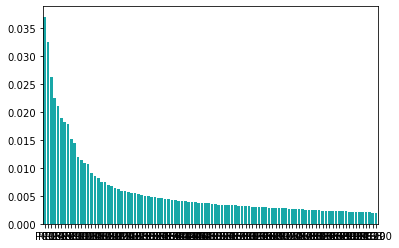

In [512]:
n_components=100
pca = PCA(n_components=n_components)
title_jiebaCut_PCA = pca.fit_transform(title_keywords_tfidf.toarray())  # csr_matrix.toarray() https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
sns.barplot(x=['PC' + str(x) for x in range(1, n_components+1)], y=pca.explained_variance_ratio_, color='c')
principalDf = pd.DataFrame(data = title_jiebaCut_PCA, columns = ['principal component ' + str(x) for x in range(1, n_components+1)])
principalDf = principalDf.reset_index().drop(['index'], axis=1)
principalDf.head()


#### Regression Model to find weights of words related to sales amount

- X, Y set
- Scaling 


In [513]:
tfidf_features = pd.DataFrame(title_keywords_tfidf.toarray())
w2v_features = pd.DataFrame(avg_title_jiebaCut_vector)
price_features = taobao_gym[['original_price', 'sale_price']]
# X = pd.concat([price_features, tfidf_features], axis=1)
# X = pd.concat([price_features, w2v_features], axis=1)
X = pd.concat([price_features, principalDf], axis=1)
X.shape
Y = taobao_gym[['number']]
Y.shape


(827, 102)

(827, 1)

In [518]:
X_train, X_test, Y_train, Y_test = train_test_split(X.head(400), Y.head(400), test_size=0.5, random_state=0)
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

X_train.shape
# X_val.shape
X_test.shape


(200, 102)

(200, 102)

In [519]:
scaler_X = StandardScaler()
scaler_X.fit(X_train)
X_train = scaler_X.transform(X_train)
# X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
scaler_Y.fit(Y_train)
Y_train = scaler_Y.transform(Y_train)
# Y_val = scaler_Y.transform(Y_val)
Y_test = scaler_Y.transform(Y_test)


StandardScaler()

StandardScaler()

LinearRegression()

0.5769

0.4231

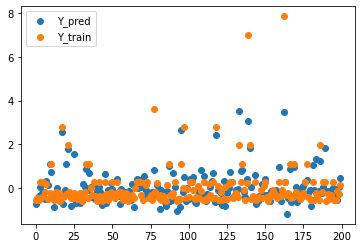

-0.2505

1.7947

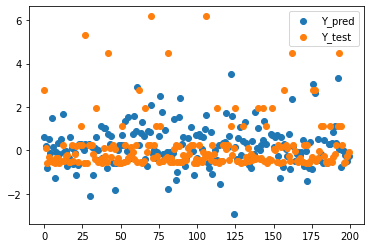

In [520]:
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_train)
round(r2_score(y_true=Y_train, y_pred=Y_pred), 4)
round(mean_squared_error(y_true=Y_train, y_pred=Y_pred), 4)
plt.scatter(list(range(0, len(Y_pred))), Y_pred.reshape(-1))
plt.scatter(list(range(0, len(Y_train))), Y_train)
plt.legend(['Y_pred', 'Y_train'])
plt.show()

# Y_pred = model.predict(X_val)
# round(r2_score(y_true=Y_val, y_pred=Y_pred), 4)
# round(mean_squared_error(y_true=Y_val, y_pred=Y_pred), 4)
# plt.scatter(list(range(0, len(Y_pred))), Y_pred.reshape(-1))
# plt.scatter(list(range(0, len(Y_val))), Y_val)
# plt.legend(['Y_pred', 'Y_val'])
# plt.show()

Y_pred = model.predict(X_test)
round(r2_score(y_true=Y_test, y_pred=Y_pred), 4)
round(mean_squared_error(y_true=Y_test, y_pred=Y_pred), 4)
plt.scatter(list(range(0, len(Y_pred))), Y_pred.reshape(-1))
plt.scatter(list(range(0, len(Y_test))), Y_test)
plt.legend(['Y_pred', 'Y_test'])
plt.show()




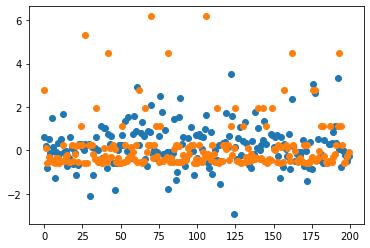

In [521]:
plt.scatter(list(range(0, len(Y_pred))), Y_pred.reshape(-1))
plt.scatter(list(range(0, len(Y_test))), Y_test)
